<a href="https://colab.research.google.com/github/tnguyennr/Intro-to-Deep-Learning/blob/final_project/Corrected_copy_Deep_Learning_Final_NBA_Player_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Daily Fantasy Sports (DFS) is an exciting way to engage with your favorite sports, such as basketball, football, and baseball, by turning your knowledge and predictions into real-world rewards. Instead of simply watching games, DFS transforms you into a strategist, building teams of real players and competing against other fans for cash prizes.  

The core concept is simple: you assemble a team of players within a set salary cap, aiming to predict their performance against projected statistics. For example, in basketball, you might select players who you believe will exceed their projected points, rebounds, or assists. In football, you could focus on players likely to surpass their projected rushing yards, passing yards, or touchdowns.


Beyond the thrill of competition, DFS offers a deeper level of engagement with sports. It encourages you to delve into player statistics, analyze matchups, and consider factors like injuries and rest. As you refine your skills and strategies, you'll gain a more comprehensive understanding of the game and potentially turn your passion into profit.  




#Data
The objective of this project is to determine how accurately we can predict points scored by a player in an NBA game.  The model will take features such as average points per game, opponent's defensive rating, and possessions per game.  Some of these variables may have nonlinear relationships to the points scored in a game variable, which make it a good candidate to use deep learning techniques.  

The data was gathered from multiple sources such as sportradar and basketball-reference.com.  This dataset includes aggregate stats for 9 different players' scoring performance over a 5 year span, aggregate stats for every teams' defensive performance over a 5 year span, and game logs for the 9 players over a 5 year span.  

In [ ]:
#Import required libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import os
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/unfinished_copy.csv')

In [ ]:
#Note that total.games_played is the number of games for the opponent team and #games_played is the games played that season for the player
df['opp.avg_def_poss'] = df['total.opponent_possessions']/df['total.games_played']
df['opp.avg_poss'] = df['total.possessions']/df['total.games_played']

df['player.avg_two_point_att'] = df['two_points_att']/df['games_played']
df['player.avg_three_point_att'] = df['three_points_att']/df['games_played']
df['player.avg_ppg'] = df['points']/df['games_played']
df.dropna(inplace = True)

In [ ]:
# Perform One-Hot Encoding
df_cleaned = pd.get_dummies(df, columns=['player'], drop_first=False)

In [ ]:
#Check
df_cleaned.sample(10)

,Date,Tm,Opp,home_game,PTS,AST,TRB,date_column,season,team,...,player.avg_ppg,player_CSex,player_CVert,player_CamJ,player_DGar,player_DMitch,player_IKoro,player_JAllen,player_Kyrie,player_LMark
1141,2023-03-08,CLE,MIA,0,7,1,7,2023-03-08,2022.0,Heat,...,12.121622,False,True,False,False,False,False,False,False,False
1109,2022-12-23,CLE,TOR,1,8,2,0,2022-12-23,2022.0,Raptors,...,12.121622,False,True,False,False,False,False,False,False,False
596,2023-12-02,CLE,DET,0,22.0,5.0,2.0,2023-12-02,2023.0,Pistons,...,18.035088,False,False,False,True,False,False,False,False,False
758,2021-11-13,CLE,BOS,1,11,1,8,2021-11-13,2021.0,Celtics,...,16.142857,False,False,False,False,False,False,True,False,False
743,2021-05-14,CLE,WAS,0,18,3,14,2021-05-14,2020.0,Wizards,...,11.166667,False,False,False,False,False,False,True,False,False
284,2024-02-07,CLE,WAS,0,40.0,5.0,8.0,2024-02-07,2023.0,Wizards,...,26.600000,False,False,False,False,True,False,False,False,False
1675,2024-03-25,UTA,DAL,1,34,2,7,2024-03-25,2023.0,Mavericks,...,23.236364,False,False,False,False,False,False,False,False,True
900,2024-01-01,CLE,TOR,0,16,4,11,2024-01-01,2023.0,Raptors,...,16.506494,False,False,False,False,False,False,True,False,False
1204,2024-02-23,CLE,PHI,0,6,4,5,2024-02-23,2023.0,76ers,...,14.000000,False,True,False,False,False,False,False,False,False
1034,2021-11-28,IND,MIL,1,23,1,2,2021-11-28,2021.0,Bucks,...,18.666667,False,True,False,False,False,False,False,False,False


In [ ]:
unwanted_list = ['Did Not Dress', 'Did Not Play', 'Not With Team']
df_cleaned = df_cleaned[~df_cleaned['PTS'].isin(unwanted_list)]
df_cleaned['PTS'] = df_cleaned['PTS'].astype(float)

In [ ]:
df_cleaned.to_csv('/content/drive/My Drive/full_10P_dataset.csv', index = False)

In [ ]:
df_cleaned = pd.read_csv('/content/drive/My Drive/full_10P_dataset.csv')

In [ ]:
eda_df = df_cleaned.copy()

eda_df['player'] = eda_df[['player_DGar', 'player_DMitch', 'player_JAllen', 'player_Kyrie', 'player_IKoro',
                              'player_LMark', 'player_CamJ', 'player_CSex', 'player_CVert']].idxmax(axis=1).str.replace('player_', '')

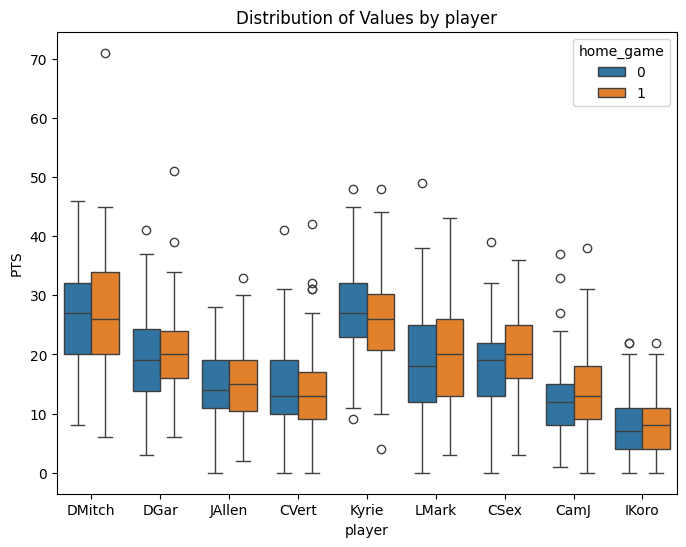

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='player', y='PTS', hue = 'home_game',data=eda_df)
plt.title('Distribution of Values by player')
plt.show()

In [ ]:

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = eda_df['PTS'].quantile(0.25)
Q3 = eda_df['PTS'].quantile(0.75)

# Calculate IQR (Interquartile Range)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the rows with outliers
eda_df_filtered = eda_df[(eda_df['PTS'] >= lower_bound) & (eda_df['PTS'] <= upper_bound)]




In [ ]:
sorted_corr = cor_mat_sub['PTS'].sort_values(ascending=False)

# Print the sorted correlations
print(sorted_corr)

PTS                            1.000000
player.avg_ppg                 0.678428
usage_pct                      0.636988
player.avg_two_point_att       0.594122
points                         0.516818
player.avg_three_point_att     0.473351
free_throws_pct                0.471598
free_throws_att                0.436160
assists                        0.334184
three_points_pct               0.142473
field_goals_at_midrange_pct    0.119628
defensive_rebounds             0.110202
rebounds                       0.073827
opp.avg_def_poss               0.049111
opp.avg_poss                   0.048477
total.defensive_rating         0.043342
average.personal_fouls         0.021874
average.blocks                 0.021800
field_goals_at_rim_pct         0.008821
true_shooting_pct              0.006703
offensive_rebounds            -0.011153
average.steals                -0.022872
average.def_rebounds          -0.030426
average.rebounds              -0.036186
points_in_paint_pct           -0.094284


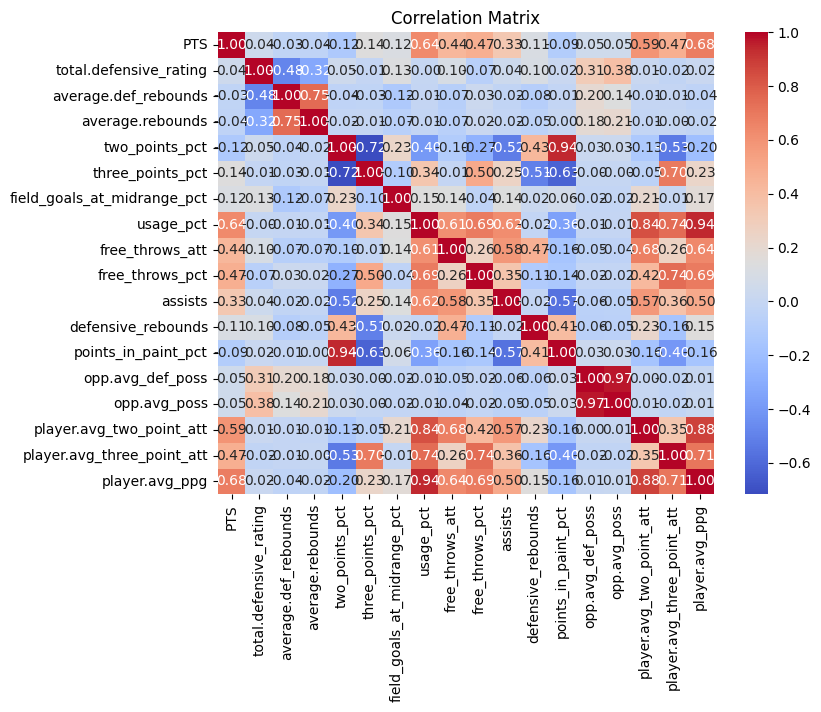

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cor_mat_sub, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
eda_df_red.to_csv('/content/drive/My Drive/full_10P_dataset_outliers_and_col_removed.csv', index = False)

In [ ]:
eda_df_red = pd.read_csv('/content/drive/My Drive/full_10P_dataset_outliers_and_col_removed.csv')

In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import pandas as pd

# Features (X) and target (y)
X = eda_df_red.drop(['PTS', 'player'], axis=1)
y = eda_df_red['PTS']  # Target (Points)

# Split the data into training and testing sets (no scaling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the MLP model with dropout
model = Sequential()

# First dense layer (input layer)
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.2))  # Dropout to reduce overfitting

# Second dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Third dense layer (optional)
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

# Output layer (for regression, no activation)
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=.001), loss='mean_squared_error')

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=10,        # Number of epochs to wait for improvement
                               restore_best_weights=True,  # Restore the best model weights after stopping
                               verbose=1)

# Train the model with EarlyStopping
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])  # Add EarlyStopping callback

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Model Loss: {loss}')

# Make predictions directly on the test set (in original scale)
predictions = model.predict(X_test)

# Create a DataFrame for easy comparison
predictions_df = pd.DataFrame(predictions, columns=['Predicted_PTS'])
true_values_df = pd.DataFrame(y_test, columns=['True_PTS'])

# Combine the true values and predictions
results_df = true_values_df.join(predictions_df)

print(results_df.head())


Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 389.7000 - val_loss: 99.2848
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 171.8661 - val_loss: 114.4668
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 118.9225 - val_loss: 126.1176
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 113.8211 - val_loss: 107.0585
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 103.5338 - val_loss: 124.3597
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 100.5871 - val_loss: 126.1166
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 95.1015 - val_loss: 107.5748
Epoch 8/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 97.3071 - val_loss: 105.7889
Epoch 9/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 89.2602 - val_loss: 99.0143
Epoch 10/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 84.1074 - val_loss: 99.6368
Epoch 11/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 82.8226 - val_loss: 105.5153
Epoch 12/200
25/25 ━━━━━━━━━━━━━━━━━━━━

In [ ]:

# # Make predictions using the trained model
# predictions = model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")



In [ ]:
X_test['player'] = X_test[['player_DGar', 'player_DMitch', 'player_JAllen', 'player_Kyrie', 'player_IKoro',
                              'player_LMark', 'player_CamJ', 'player_CSex', 'player_CVert']].idxmax(axis=1).str.replace('player_', '')

In [ ]:
y = results.groupby('player')['squared_error'].mean()
x = results.groupby('player')['player']

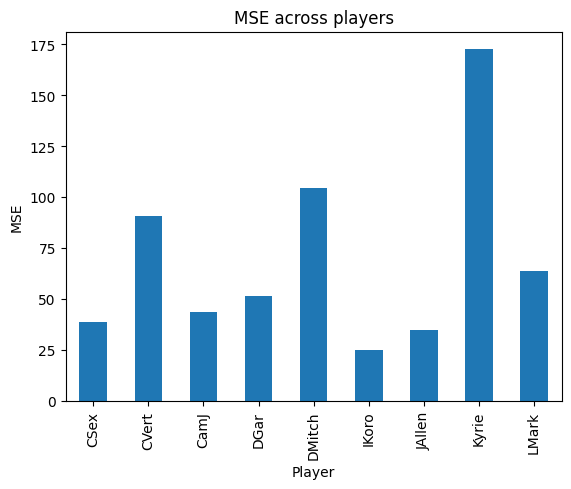

In [ ]:
y.plot(kind = 'bar')
plt.title('MSE across players')
plt.ylabel('MSE')
plt.xlabel('Player')

plt.show()

# Results and Conclusion

Model 1 performed better than Model 2 in terms of our MSE/RMSE metric, but did not perform equally well across all players.  

The next steps to continue iterating on this project could be to collect more data such as data on additional players and games, and determine if there are similarities in players the model performs better for.  We could potentially apply clustering techniques to explore this idea further.  Feature engineering could also be included to take inputs such as last 3 games average into account.  

Finally, we'll use this model to make predictions on new data and record the results to see if the model has a tendency to over or under estimate relative to the lines that are set.  We could also create additinoal models to predict on other game stats such as rebounds or assists.
